In [13]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0


In [14]:
!nvidia-smi

Tue Mar  4 18:27:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:02:00.0  On |                  N/A |
| 53%   45C    P3             25W /  170W |     809MiB /  12288MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
import numpy as np
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
import cv2
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras


In [16]:
train_data = "/home/aman/Projects/traffic-recognition/ml/data/external/train"

In [17]:
def convert_to_greyscale(image):
    """
    Formula used: G = 0.2989 * R + 0.5870 * G + 0.1140 * B
    """

    if image.shape[-1] == 3:  # Check if it's a color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]
    grey_image = 0.2989 * R + 0.5870 * G + 0.1140 * B
    grey_image = np.uint8(grey_image)

    return grey_image

def binary_threshold_no_cv(image, threshold_value=127):
    """
    Convert an image to binary using manual thresholding.
    
    :param image: The input image (grayscale).
    :param threshold_value: The threshold value to classify pixels as either black or white.
    :return: Binary thresholded image.
    """
    if isinstance(image, Image.Image):
        image = np.array(image)

    binary_image = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(image.shape[0]):  # iterate over rows
        for j in range(image.shape[1]):  # iterate over columns
            if image[i, j] > threshold_value:
                binary_image[i, j] = 255  # Set pixel to white
            else:
                binary_image[i, j] = 0    # Set pixel to black

    return binary_image

In [18]:
def loadDataSet(dataPath):
    data = []
    imageSize = 28
    for cat in os.listdir(dataPath):
        label = int(cat[:2])
        for i in os.listdir(dataPath+'/'+cat):
            imagePath = dataPath+'/'+cat+'/'+i
            try:
                image = cv2.imread(imagePath,0) 
                image = cv2.resize(image,(imageSize,imageSize))
                data.append([image,label])
            except:
                pass
    
    random.shuffle(data)
    
    X = [] #image
    Y = [] #labels
    for img,l in data: 
        X.append(img)
        Y.append(l)
    X = np.array(X)
    Y = np.array(Y).reshape(len(Y),1)
    return X,Y

In [19]:
images, labels = loadDataSet(train_data)

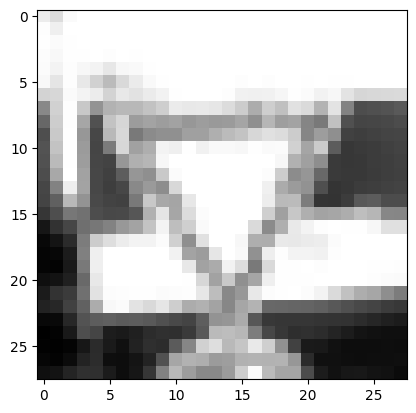

[3]


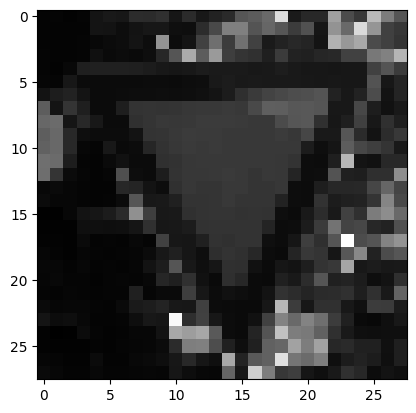

[3]


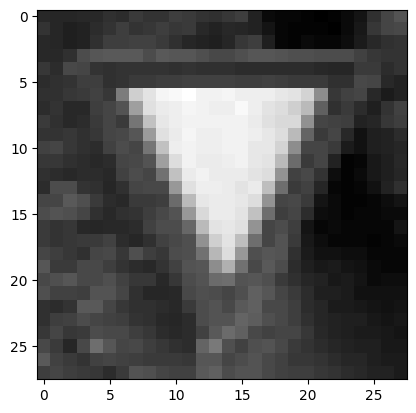

[3]


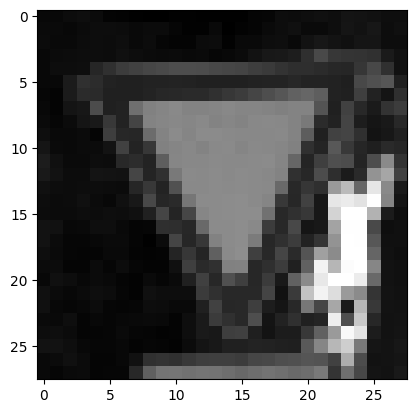

[3]


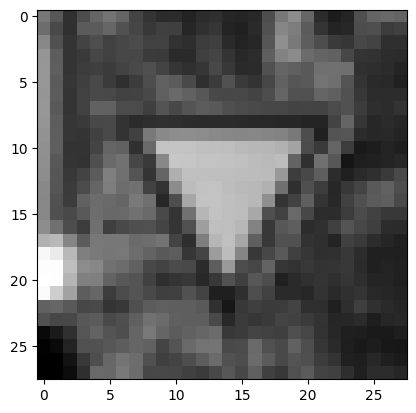

[3]


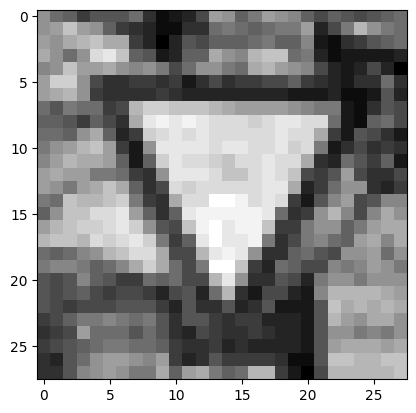

[3]


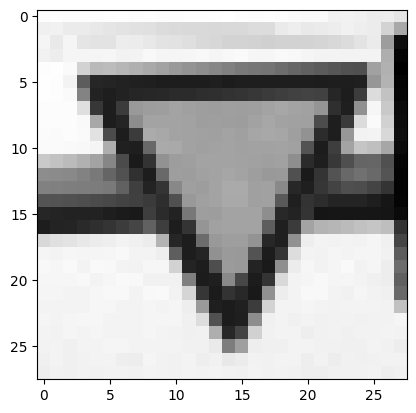

[3]


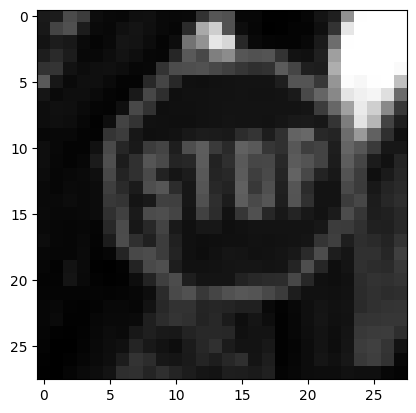

[0]


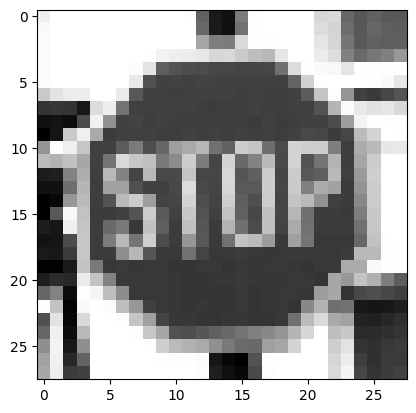

[0]


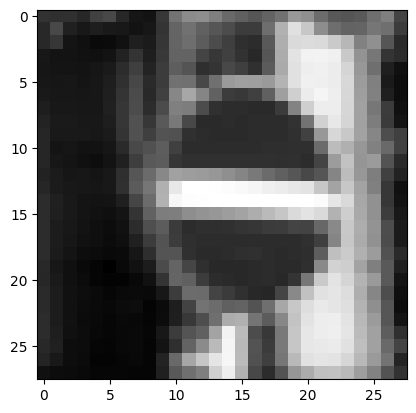

[1]


In [20]:
for i in range(10):
    plt.imshow(images[i],cmap='gray')
    plt.show()
    print(labels[i])

In [21]:
mu = np.mean(images)
std = np.std(images)
print("The Mean = ",mu)
print("The Standard Deviation = ",std)

The Mean =  92.39488493223836
The Standard Deviation =  70.77168647587727


In [22]:
images.shape

(4739, 28, 28)

In [23]:
m = images.shape[0]
imageShape = images.shape[1:]

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(images,labels,test_size=0.2,random_state=0)
print("Count of Training Example = ",x_train.shape[0])
print("Count of Validation Example = ",x_test.shape[0])

Count of Training Example =  3791
Count of Validation Example =  948


In [25]:
x_train_Norm = (x_train - mu) / std
x_test_Norm  = (x_test - mu) / std
x_train_Norm = x_train_Norm.reshape(3791, 28, 28,1)
x_test_Norm = x_test_Norm.reshape(948, 28, 28,1)

In [26]:
def preprocessingImage(image=None,imageSize=28,mu=89.77428691773054,std=70.85156431910688):
    try:
        image = convert_to_greyscale(image)
    except:
        pass
    image = cv2.resize(image,(imageSize,imageSize))
    image = (image - mu) / std
    image = image.reshape(1,imageSize,imageSize,1)
    return image

In [27]:
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.997):
            self.model.stop_training=True

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Define the model
model = keras.Sequential([
    keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(pool_size=(4,4)),  # Corrected naming: MaxPool2D → MaxPooling2D
    keras.layers.Flatten(),
    keras.layers.Dense(4, activation='softmax')  # Corrected activation syntax
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()
    

/home/aman/Projects/traffic-recognition/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,236 (4.83 KB)

 Trainable params: 1,236 (4.83 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
#Fitting 
model.fit(x_train_Norm,
          y_train,
          epochs = 15,
          callbacks = [myCallBack()])

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4636 - loss: 1.1815
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8419 - loss: 0.6217
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9306 - loss: 0.3341
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9610 - loss: 0.2149
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9739 - loss: 0.1545
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9838 - loss: 0.1129
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9856 - loss: 0.0935
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9895 - loss: 0.0777
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9917 - loss: 0.0645
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0554
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0441
Epoch 12/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [40]:
model.evaluate(x_test_Norm,
               y_test,
               verbose = 0)

[0.045456189662218094, 0.9883966445922852]

In [41]:
model.save('/home/aman/Projects/traffic-recognition/ml/src/models/TSModel.keras')

In [51]:
model=keras.models.load_model('/home/aman/Projects/traffic-recognition/ml/src/models/TSModel.keras')

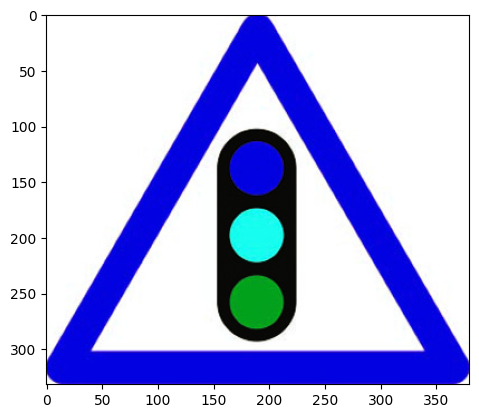

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Stop = 1.8063694%
Do not Enter = 9.851922e-08%
Traffic Jam = 98.19363%
Yeild = 3.468353e-07%


In [52]:
imgPath="/home/aman/Projects/traffic-recognition/ml/data/external/test/02/3.jpg"
image = cv2.imread(imgPath,1)
plt.imshow(image)
plt.show()
img=preprocessingImage(image)
pred=model.predict(img)*100 # 4*1

print("Stop = "+str(pred[0][0])+"%")
print("Do not Enter = " + str(pred[0][1])+"%")
print("Traffic Jam = "+str(pred[0][2])+"%")
print("Yeild = "+str(pred[0][3])+"%")